In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/aqt/'))

In [2]:
import numpy as np
import networkx as nx
from itertools import product
import numba as nb
import copy
import matplotlib.pyplot as plt
from scipy import optimize

In [3]:
import numpy as np

import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *

from matplotlib import pyplot as plt
%matplotlib inline

In [84]:
import networkx as nx
import numpy as np
import glob
from sys import platform as _platform


def generate_butterfly_graph(with_weights=False):
    # Generate a graph of 5 nodes
    # filename = graph_05_06_02_w.txt
    n = 5
    graph = nx.Graph()
    graph.add_nodes_from(np.arange(0, n, 1))
    if with_weights:
        elist = [(0, 3, 9), (0, 4, 6), (1, 2, 9), (1, 4, 10), (2, 4, 7), (3, 4, 7)]
        graph.name = "graph_05_06_02_w"
    else:
        elist = [(0, 3, 1), (0, 4, 1), (1, 2, 1), (1, 4, 1), (2, 4, 1), (3, 4, 1)]
        graph.name = "graph_05_06_02"
    graph.add_weighted_edges_from(elist)
    
    return graph

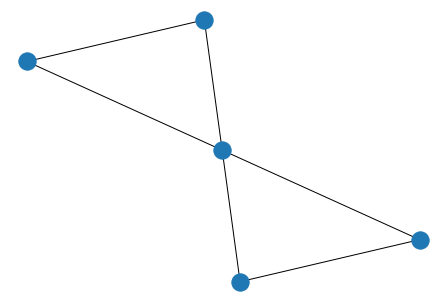

In [370]:
# Set everything up and show the graph
#N = 16
seed = 42 
# = load_nx_graph_from("/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/data/graphs/16_nodes/graph_16_33_01_w.txt")
#G = load_nx_graph_from("/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/measurements/data/graph_3_reg_10_15_01.txt")

G = generate_butterfly_graph(with_weights=False)
edges = nx.edge_betweenness(G).keys()
nodes = G.nodes
N = len(nodes)
nx.draw(G)
initial_state = np.ones(2 ** N) / np.sqrt(2) ** N
# Create full Hilbertspace to use in creation of the Hamiltonians
H = np.array(list(product([1, -1], repeat=N)))

In [371]:

# Fast Hadamard transformation

@nb.njit # Just in time compilation for massive speed-up
def fwht(a):
    h = 1
    tmp = a.copy()
    while 2 * h <= len(a):
        for i in range(0, len(a) - 1, h * 2):
            for j in range(i, i + h):
                x = tmp[j]
                y = tmp[j + h]
                tmp[j] = x + y
                tmp[j + h] = x - y
        h *= 2
    return tmp

def ifwht(a):
    return fwht(a) / len(a)

In [372]:
# Classical Hamiltonian, the ground state is the MaxCut solution
# we use the QAOA to find an approximation to the ground state variationally
def H_C():
    tmp = np.zeros(2**N)
    for i, j in edges:
        tmp += H[:, i] * H[:, j]
    return tmp

In [373]:
# Quantum Hamiltonian, the ground state is an equal superposition of all solutions, i.e. all possible graph cuts
def H_B():
    tmp = np.zeros(2**N)
    for i in nodes:
        tmp += H[:, i]
    return tmp

In [374]:
def qaoa_state(x):

    # Create the QAOA ansatz state, note that we use a fast Hadamard 
    # transformation (n log(n)) to keep the operators diagonal and use vector-vector 
    # multiplication rather than matrix-vector mutliplication where the 
    # matrix would be the matrix exponential of H_B which would be very slow

    beta, gamma = np.split(x, 2)
    state = copy.copy(initial_state)

    for g, b in zip(gamma, beta):

        state = np.exp(1j * g * H_C()) * state
        state = fwht(state)              # Fast Hadamard transformation
        state = np.exp(-1j * b * H_B()) * state
        state = ifwht(state)             # inverse Fast Hadamard transformation

    return state

In [375]:
def energy_expectation_value(state):
    return np.real(np.vdot(state, H_C() * state))

In [376]:

# Loop over different evolution times
time = np.linspace(0.1, 4, 200)

energies = []
for p in [1,2,3,4]:
    energy = []
    for t_max in time: 
        
        dt = t_max / p
        t = dt * (np.arange(1, p + 1) - 0.5)
        gamma = (t / t_max) * dt
        beta = (1 - (t / t_max)) * dt
        x = np.concatenate((beta, gamma))
        energy.append(energy_expectation_value(qaoa_state(x)))

    energies.append(energy)

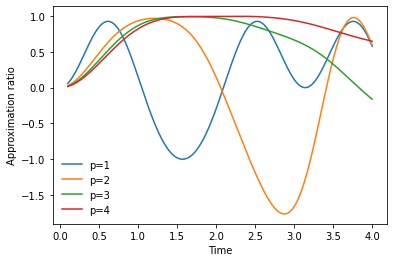

In [377]:

plt.plot(time, energies[0]/min(H_C()), label="p=1")
plt.plot(time, energies[1]/min(H_C()), label="p=2")
plt.plot(time, energies[2]/min(H_C()), label="p=3")
plt.plot(time, energies[3]/min(H_C()), label="p=4")
plt.xlabel('Time')
plt.ylabel('Approximation ratio')
plt.legend(frameon=False)

In [378]:
# Find optimal time 
idx = np.argmin(energies[0])
t_max = time[idx]
print(f'Optimal evolution time is {t_max} with an approximation ratio of {energies[0][idx]/min(H_C())}')

Optimal evolution time is 2.5301507537688446 with an approximation ratio of 0.9258245513432753


In [379]:
# Fix initial beta and gamma values
p = 1
dt = t_max / p
t = dt * (np.arange(1, p + 1) - 0.5)
gamma = (t / t_max) * dt
beta = (1 - (t / t_max)) * dt
x0 = np.concatenate((beta, gamma))

In [380]:
gamma

array([1.26507538])

In [381]:
beta

array([1.26507538])

In [382]:
func_to_optimize = lambda x: energy_expectation_value(qaoa_state(x))
result_tqa = optimize.minimize(func_to_optimize, x0, method='BFGS')

In [383]:
print(f'Final approximation ratio from TQA init. is {result_tqa.fun/min(H_C())}')


Final approximation ratio from TQA init. is 0.9287644729543479


In [384]:
# Quick comparison with a single QAOA run lauched from a random initialization
x0_random = np.concatenate((np.random.uniform(-np.pi/4, np.pi/4, p), np.random.uniform(-np.pi/2, np.pi/2, p)))
result_rand = optimize.minimize(func_to_optimize, x0_random, method='BFGS')

In [385]:
print(f'Final approximation ratio from random init. is {result_rand.fun/min(H_C())}')


Final approximation ratio from random init. is 0.928764472954355


In [386]:
max_cut = Maxcut(G, -4)
max_cut_qubo = max_cut.to_qubo()
from qiskit.algorithms.minimum_eigen_solvers.qaoa import QAOA
quantum_instance = QuantumInstance(
                    backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                    shots=SHOTS)
qaoa = QAOA(
            optimizer=COBYLA(maxiter=0),
            quantum_instance=quantum_instance,
            reps=p,
            initial_point=np.concatenate((gamma,beta))
            )

op, offset = max_cut_qubo.to_ising()
from qiskit_optimization.algorithms.minimum_eigen_optimizer import (
    MinimumEigenOptimizer,
    MinimumEigenOptimizationResult,
)
result = MinimumEigenOptimizer(qaoa).solve(max_cut_qubo)
max_cut.analyse(result, print_output=True)

optimal function value: -4.0
optimal value: [1. 1. 0. 0. 0.]
status: SUCCESS
Number of samples (32) is too large to display. Skip.
Expectation Value: -3.199250000000001
Highest Exp.Value: 0 with 0.6125 %
Lowest Exp.Value: -4 with 60.575 %
Highest Probability: -4 with 60.575 %
Ratio r: 0.7998125000000003
Approiximation ratio: 0.7998125000000003
MSE: 4.104867229166669
RMSE: 2.0260471932229684


(-3.199250000000001,
 {-4: 0.6057500000000001, -2: 0.38812500000000005, 0: 0.006125})

In [387]:
import numpy as np
import networkx as nx
from itertools import product
import numba as nb
import copy
from scipy import optimize

#
# http://127.0.0.1:8888/notebooks/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/TQA.ipynb 
#
# Fast Hadamard transformation

@nb.njit # Just in time compilation for massive speed-up
def fwht(a):
    h = 1
    tmp = a.copy()
    while 2 * h <= len(a):
        for i in range(0, len(a) - 1, h * 2):
            for j in range(i, i + h):
                x = tmp[j]
                y = tmp[j + h]
                tmp[j] = x + y
                tmp[j + h] = x - y
        h *= 2
    return tmp

def ifwht(a):
    return fwht(a) / len(a)

# Classical Hamiltonian, the ground state is the MaxCut solution
# we use the QAOA to find an approximation to the ground state variationally
def H_C():
    
    if is_weighted:
        return H_C_weighted()

    tmp = np.zeros(2**N)
    for i, j in edges:
        tmp += H[:, i] * H[:, j]
    return tmp

# Quantum Hamiltonian, the ground state is an equal superposition of all solutions, i.e. all possible graph cuts
def H_B():
    tmp = np.zeros(2**N)
    for i in nodes:
        tmp += H[:, i]
    return tmp

def init_weights(N, seed):

    np.random.seed(seed)
    a = np.random.rand(N, N)
    return np.tril(a) + np.tril(a, -1).T

def H_C_weighted():

    tmp = np.zeros(2**N)
    for i, j in edges:
        tmp += weights[i, j] * H[:, i] * H[:, j]
    return tmp

def qaoa_state(x):

    # Create the QAOA ansatz state, note that we use a fast Hadamard 
    # transformation (n log(n)) to keep the operators diagonal and use vector-vector 
    # multiplication rather than matrix-vector mutliplication where the 
    # matrix would be the matrix exponential of H_B which would be very slow

    beta, gamma = np.split(x, 2)
    state = copy.copy(initial_state)

    for g, b in zip(gamma, beta):

        state = np.exp(1j * g * H_C()) * state
        state = fwht(state)              # Fast Hadamard transformation
        state = np.exp(-1j * b * H_B()) * state
        state = ifwht(state)             # inverse Fast Hadamard transformation

    return state

def energy_expectation_value(state):
    return np.real(np.vdot(state, H_C() * state))

def calculate_tqa(graph, p, print_info=True):
    global edges, nodes, initial_state, H, N, weights, is_weighted
    
    is_weighted = False 
    edges = nx.edge_betweenness(graph).keys()
    nodes = graph.nodes
    N = len(nodes)
    initial_state = np.ones(2 ** N) / np.sqrt(2) ** N
    # Create full Hilbertspace to use in creation of the Hamiltonians
    H = np.array(list(product([1, -1], repeat=N)))
    
    for u,v,w in graph.edges(data=True):
        if w['weight'] != 1:
            # from paper: 
            weights = init_weights(N, 42)
            #is_weighted = True 
            # my idea:
            # weights = nx.adjacency_matrix(graph).todense()
            #print(weights)
            is_weighted=True
            break
    
    # Loop over different evolution times
    time = np.linspace(0.1, N+p, 200)
    
    energy = []
    for t_max in time: 
        dt = t_max / p
        t = dt * (np.arange(1, p + 1) - 0.5)
        gamma = (t / t_max) * dt
        beta = (1 - (t / t_max)) * dt
        x = np.concatenate((beta, gamma))
        energy.append(energy_expectation_value(qaoa_state(x)))
        
    # Find optimal time 
    idx = np.argmin(energy)
    t_max = time[idx]
    # Fix initial beta and gamma values
    dt = t_max / p
    t = dt * (np.arange(1, p + 1) - 0.5)
    gamma = (t / t_max) * dt
    beta = (1 - (t / t_max)) * dt
    
    #tqa_initial_points = np.concatenate([beta,gamma])
    tqa_initial_points = np.concatenate([gamma,beta])
    print(f"TQA: Beta: {beta}, Gamma: {gamma} (p={p})")
    
    return tqa_initial_points, time, energy, idx
    


    
    

In [388]:
energies = []
idxs = []
for i in range(1,5):
    _, time, energy, idx = calculate_tqa(G, i)
    energies.append(energy)
    idxs.append(idx)

TQA: Beta: [1.26557789], Gamma: [1.26557789] (p=1)
TQA: Beta: [1.41576633 0.47192211], Gamma: [0.47192211 1.41576633] (p=2)
TQA: Beta: [0.45784478 0.27470687 0.09156896], Gamma: [0.09156896 0.27470687 0.45784478] (p=3)
TQA: Beta: [0.49147299 0.35105214 0.21063128 0.07021043], Gamma: [0.07021043 0.21063128 0.35105214 0.49147299] (p=4)


In [389]:
idxs

[82, 106, 39, 48]

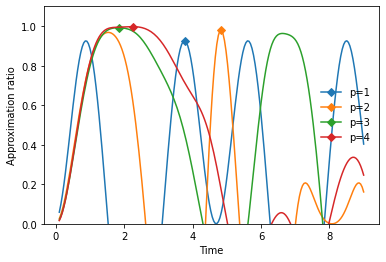

In [390]:
plt.plot(time, energies[0]/min(H_C()),'-D', label="p=1", markevery=[idxs[0]])
plt.plot(time, energies[1]/min(H_C()),'-D', label="p=2", markevery=[idxs[1]])
plt.plot(time, energies[2]/min(H_C()),'-D', label="p=3", markevery=[idxs[2]])
plt.plot(time, energies[3]/min(H_C()),'-D', label="p=4", markevery=[idxs[3]])
plt.xlabel('Time')
plt.ylabel('Approximation ratio')
plt.ylim([0,1.1])
plt.legend(frameon=False)